In [1]:
import warnings
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.linear_model import Lasso

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# 데이터 불러오는 함수
def load_data(train_path, test_path, rul_path, column_names):
    train = pd.read_csv(train_path, header=None, sep='\s+')
    test = pd.read_csv(test_path, header=None, sep='\s+')
    RUL = pd.read_csv(rul_path, header=None, sep='\s+')

    train.columns = column_names
    test.columns = column_names
    
    return train, test, RUL

# RUL 계산해서 데이터에 넣어주는 함수
def add_rul_column(train, test, RUL):
    max_cycle_per_id = train.groupby('id')['cycle'].max().reset_index()
    max_cycle_per_id.columns = ['id', 'max_cycle']
    train = pd.merge(train, max_cycle_per_id, on='id')
    train['RUL'] = train['max_cycle'] - train['cycle']
    train = train.drop(columns=['max_cycle'])
    RUL.columns = ['RUL']
    test = test.groupby('id').last().reset_index()
    test['RUL'] = RUL['RUL']

    return train, test

# 우리가 이미 논의했던 기본적인 전처리들만 진행합니다
# 제거해야 하는 컬럼들, RUL에 clip 거는 것
def preprocess_data_base(train, test):
    pre_df_train_base = train.drop(
        columns=['id', 'setting1', 'setting2', 'setting3'])
    pre_df_test_base = test.drop(
        columns=['id', 'setting1', 'setting2', 'setting3'])

    X_train_base = pre_df_train_base.drop(columns=['RUL'])
    y_train_base = pre_df_train_base['RUL'].clip(upper=125)
    X_test_base = pre_df_test_base.drop(columns=['RUL'])
    y_test_base = pre_df_test_base['RUL'].clip(upper=125)
    
    return X_train_base, X_test_base, y_train_base, y_test_base

In [18]:
def XGB(X_train, X_test, y_train, y_test):
    def objective(trial):
        param = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 0, 5),
            'alpha': trial.suggest_float('alpha', 0, 5)
        }

        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=1)

        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        return mse

    # 최적 하이퍼파라미터 출력
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print(f"Best parameters: {study.best_params}")

    # 최적 하이퍼파라미터로 모델 학습 및 평가
    best_params = study.best_params
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train, verbose = 1)

    # 예측
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # 평가
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    non_zero_indices_train = y_train != 0
    train_error_ratio = np.abs(y_train[non_zero_indices_train] - y_pred_train[non_zero_indices_train]) / \
                        y_train[non_zero_indices_train]

    # Test error ratio 계산
    non_zero_indices_test = y_test != 0
    test_error_ratio = np.abs(y_test[non_zero_indices_test] - y_pred_test[non_zero_indices_test]) / \
                       y_test[non_zero_indices_test]

    # 평균 오차 비율
    mean_train_error_ratio = np.mean(train_error_ratio)
    mean_test_error_ratio = np.mean(test_error_ratio)
    print(f"XGB Train MSE: {mse_train}, Train R^2: {r2_train}")
    print(f"XGB Test MSE: {mse_test}, Test R^2: {r2_test}")
    print(f"XGB Mean Train Error Ratio: {mean_train_error_ratio:.2f}")
    print(f"XGB Mean Test Error Ratio: {mean_test_error_ratio:.2f}")
    # 중요도 시각화
    xgb.plot_importance(model)
    plt.show()
    
    return 

In [27]:
def RF_reg(X_train, X_test, y_train, y_test):
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
        }

        model = RandomForestRegressor(**param, random_state=42, verbose = 1)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # 최적 하이퍼파라미터 출력
    print(f"Best parameters: {study.best_params}")

    # 최적 하이퍼파라미터로 모델 학습 및 평가
    best_params = study.best_params
    rf_model = RandomForestRegressor(**best_params, random_state=42, verbose = 1)
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred_train_rf = rf_model.predict(X_train)
    y_pred_test_rf = rf_model.predict(X_test)

    # 평가
    mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
    r2_train_rf = r2_score(y_train, y_pred_train_rf)
    mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
    r2_test_rf = r2_score(y_test, y_pred_test_rf)
    non_zero_indices_train = y_train != 0
    train_error_ratio = np.abs(
        y_train[non_zero_indices_train] - y_pred_train_rf[non_zero_indices_train]) / \
                        y_train[non_zero_indices_train]

    # Test error ratio 계산
    non_zero_indices_test = y_test != 0
    test_error_ratio = np.abs(y_test[non_zero_indices_test] - y_pred_test_rf[non_zero_indices_test]) / \
                       y_test[non_zero_indices_test]

    # 평균 오차 비율
    mean_train_error_ratio = np.mean(train_error_ratio)
    mean_test_error_ratio = np.mean(test_error_ratio)

    print(f"Random Forest - Train MSE: {mse_train_rf}, Train R^2: {r2_train_rf}")
    print(f" Random Forest - Test MSE: {mse_test_rf}, Test R^2: {r2_test_rf}")
    print(f"Random Forest - Mean Train Error Ratio: {mean_train_error_ratio:.2f}")
    print(f"Random Forest - Mean Test Error Ratio: {mean_test_error_ratio:.2f}")

    # 중요도 시각화
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.title("Feature Importances")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [28]:
def Ln_reg(X_train, X_test, y_train, y_test):
    def objective(trial):
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        model = LinearRegression(fit_intercept=fit_intercept)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터로 모델 학습
    best_params = study.best_params
    model = LinearRegression(**best_params)
    model.fit(X_train, y_train)

    # 예측값 계산
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # MSE와 R^2 계산
    mse_train_lr = mean_squared_error(y_train, y_train_pred)
    r2_train_lr = r2_score(y_train, y_train_pred)
    mse_test_lr = mean_squared_error(y_test, y_test_pred)
    r2_test_lr = r2_score(y_test, y_test_pred)
    non_zero_indices_train = y_train != 0
    train_error_ratio = np.abs(y_train[non_zero_indices_train] - y_train_pred[non_zero_indices_train]) / \
                        y_train[non_zero_indices_train]

    # Test error ratio 계산
    non_zero_indices_test = y_test != 0
    test_error_ratio = np.abs(y_test[non_zero_indices_test] - y_test_pred[non_zero_indices_test]) / \
                       y_test[non_zero_indices_test]

    # 평균 오차 비율
    mean_train_error_ratio = np.mean(train_error_ratio)
    mean_test_error_ratio = np.mean(test_error_ratio)

    print(f"Linear Regression - Train MSE: {mse_train_lr}, Train R^2: {r2_train_lr}")
    print(f"Linear Regression - Test MSE: {mse_test_lr}, Test R^2: {r2_test_lr}")
    print(f"Linear Regression - Mean Train Error Ratio: {mean_train_error_ratio:.2f}")
    print(f"Linear Regression - Mean Test Error Ratio: {mean_test_error_ratio:.2f}")

In [30]:
def Rd_reg(X_train, X_test, y_train, y_test):
    def objective(trial):
        alpha = trial.suggest_float('alpha', 0.1, 10.0)
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    best_params = study.best_params
    print("Best parameters:", best_params)

    # 최적 파라미터로 모델 훈련 및 평가
    best_model = Ridge(**best_params)
    best_model.fit(X_train, y_train)

    y_train_pred = best_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    y_test_pred = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    non_zero_indices_train = y_train != 0
    train_error_ratio = np.abs(y_train[non_zero_indices_train] - y_train_pred[non_zero_indices_train]) / \
                        y_train[non_zero_indices_train]

    # Test error ratio 계산
    non_zero_indices_test = y_test != 0
    test_error_ratio = np.abs(y_test[non_zero_indices_test] - y_test_pred[non_zero_indices_test]) / \
                       y_test[non_zero_indices_test]

    # 평균 오차 비율
    mean_train_error_ratio = np.mean(train_error_ratio)
    mean_test_error_ratio = np.mean(test_error_ratio)
    print(f"Ridge - Train MSE: {mse_train}, Train R^2: {r2_train}")
    print(f"Ridge - Test MSE: {mse_test}, Test R^2: {r2_test}")
    print(f"Ridge - Mean Train Error Ratio: {mean_train_error_ratio:.2f}")
    print(f"Ridge - Mean Test Error Ratio: {mean_test_error_ratio:.2f}")

In [36]:
def Rs_reg(X_train, X_test, y_train, y_test):
    def objective(trial):
        param = {
            'alpha': trial.suggest_float('alpha', 0.0001, 1.0, log=True),
            'max_iter': trial.suggest_int('max_iter', 100, 1000)
        }

        model = Lasso(**param, random_state=42)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터로 모델 학습
    best_params = study.best_params
    model = Lasso(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # 예측값 계산
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # MSE와 R^2 계산
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    non_zero_indices_train = y_train != 0
    train_error_ratio = np.abs(y_train[non_zero_indices_train] - y_train_pred[non_zero_indices_train]) / \
                        y_train[non_zero_indices_train]

    # Test error ratio 계산
    non_zero_indices_test = y_test != 0
    test_error_ratio = np.abs(y_test[non_zero_indices_test] - y_test_pred[non_zero_indices_test]) / \
                       y_test[non_zero_indices_test]

    # 평균 오차 비율
    mean_train_error_ratio = np.mean(train_error_ratio)
    mean_test_error_ratio = np.mean(test_error_ratio)

    print(f"Rasso - Train MSE: {mse_train}, Train R^2: {r2_train}")
    print(f"Rasso - Test MSE: {mse_test}, Test R^2: {r2_test}")
    print(f"Rasso - Mean Train Error Ratio: {mean_train_error_ratio:.2f}")
    print(f"Rasso - Mean Test Error Ratio: {mean_test_error_ratio:.2f}")

In [38]:
def Els_reg(X_train, X_test, y_train, y_test):
        def objective(trial):
            param = {
                'alpha': trial.suggest_float('alpha', 0.0001, 1.0, log=True),
                'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
                'max_iter': trial.suggest_int('max_iter', 100, 1000)
            }

            model = ElasticNet(**param, random_state=42)
            model.fit(X_train, y_train)

            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            return mse

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=50)

        # 최적의 하이퍼파라미터로 모델 학습
        best_params = study.best_params
        print("Best parameters:", best_params)

        model = ElasticNet(**best_params, random_state=42)
        model.fit(X_train, y_train)

        # 예측값 계산
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # MSE와 R^2 계산
        mse_train = mean_squared_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        # Train error ratio 계산
        non_zero_indices_train = y_train != 0
        train_error_ratio = np.abs(y_train[non_zero_indices_train] - y_train_pred[non_zero_indices_train]) / \
                            y_train[non_zero_indices_train]

        # Test error ratio 계산
        non_zero_indices_test = y_test != 0
        test_error_ratio = np.abs(y_test[non_zero_indices_test] - y_test_pred[non_zero_indices_test]) / \
                           y_test[non_zero_indices_test]

        # 평균 오차 비율
        mean_train_error_ratio = np.mean(train_error_ratio)
        mean_test_error_ratio = np.mean(test_error_ratio)

        print(f"Elasticnet - Train MSE: {mse_train}, Train R^2: {r2_train}")
        print(f"Elasticnet - Test MSE: {mse_test}, Test R^2: {r2_test}")
        print(f"Elasticnet - Mean Train Error Ratio: {mean_train_error_ratio:.2f}")
        print(f"Elasticnet - Mean Test Error Ratio: {mean_test_error_ratio:.2f}")

In [4]:
# 경로 설정하는 부분, column 이름 정하는 부분
# 경로는 여러분들의 환경에 맞게 설정!
train_path = 'train_FD001.txt'
test_path = 'test_FD001.txt'
rul_path = 'RUL_FD001.txt'
column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]

In [5]:
# 원본 데이터를 불러오는 부분
train, test, RUL = load_data(train_path, test_path, rul_path, column_names)

In [9]:
# 원본 데이터에서 RUL 값들을 집어 넣는 부분
train, test = add_rul_column(train, test, RUL)

In [12]:
# 우리가 기본적으로 논의했던 전처리를 진행하는 부분
# 1. RUL 125기준으로 넘는 것들은 전부 125가 되도록 clip
# 2. id, settings 컬럼들 삭제
X_train, X_test, y_train, y_test = preprocess_data_base(train, test)

In [41]:
# 추가적인 전처리, 가공 등을 하고자 한다면 여기서 코드를 추가!
# X_train, X_test를 가져와서 전처리 및 가공을 진행하면 됨!
# 아래는 전부 순차적으로 머신러닝 모델 돌리기!

[0]	validation_0-rmse:67.99745
[1]	validation_0-rmse:55.77179
[2]	validation_0-rmse:46.21494
[3]	validation_0-rmse:38.79348
[4]	validation_0-rmse:32.86325
[5]	validation_0-rmse:28.33319
[6]	validation_0-rmse:24.81188
[7]	validation_0-rmse:22.31575
[8]	validation_0-rmse:20.47804
[9]	validation_0-rmse:19.02019
[10]	validation_0-rmse:18.14183
[11]	validation_0-rmse:17.49376
[12]	validation_0-rmse:17.02796
[13]	validation_0-rmse:16.84553
[14]	validation_0-rmse:16.59151
[15]	validation_0-rmse:16.48016
[16]	validation_0-rmse:16.45733
[17]	validation_0-rmse:16.42358
[18]	validation_0-rmse:16.43392
[19]	validation_0-rmse:16.48047
[20]	validation_0-rmse:16.44251
[21]	validation_0-rmse:16.42517
[22]	validation_0-rmse:16.41886
[23]	validation_0-rmse:16.42771
[24]	validation_0-rmse:16.44064
[25]	validation_0-rmse:16.47303
[26]	validation_0-rmse:16.46458
[27]	validation_0-rmse:16.49093
[28]	validation_0-rmse:16.50252
[29]	validation_0-rmse:16.52379
[30]	validation_0-rmse:16.54554
[31]	validation_0-

[13]	validation_0-rmse:19.33958
[14]	validation_0-rmse:18.52044
[15]	validation_0-rmse:17.88777
[16]	validation_0-rmse:17.38533
[17]	validation_0-rmse:17.11981
[18]	validation_0-rmse:16.87029
[19]	validation_0-rmse:16.70378
[20]	validation_0-rmse:16.65636
[21]	validation_0-rmse:16.50915
[22]	validation_0-rmse:16.44611
[23]	validation_0-rmse:16.42112
[24]	validation_0-rmse:16.36544
[25]	validation_0-rmse:16.35415
[26]	validation_0-rmse:16.32681
[27]	validation_0-rmse:16.31837
[28]	validation_0-rmse:16.29954
[29]	validation_0-rmse:16.34813
[30]	validation_0-rmse:16.34431
[31]	validation_0-rmse:16.38338
[32]	validation_0-rmse:16.39538
[33]	validation_0-rmse:16.48363
[34]	validation_0-rmse:16.51571
[35]	validation_0-rmse:16.61303
[36]	validation_0-rmse:16.64229
[37]	validation_0-rmse:16.67796
[38]	validation_0-rmse:16.66440
[0]	validation_0-rmse:73.02650
[1]	validation_0-rmse:63.32166
[2]	validation_0-rmse:55.00246
[3]	validation_0-rmse:48.22113
[4]	validation_0-rmse:42.25984
[5]	validatio

[74]	validation_0-rmse:21.33762
[75]	validation_0-rmse:21.11307
[76]	validation_0-rmse:20.90028
[77]	validation_0-rmse:20.71158
[78]	validation_0-rmse:20.52597
[79]	validation_0-rmse:20.36105
[80]	validation_0-rmse:20.18346
[81]	validation_0-rmse:20.01286
[82]	validation_0-rmse:19.87556
[83]	validation_0-rmse:19.72566
[84]	validation_0-rmse:19.59790
[85]	validation_0-rmse:19.45670
[86]	validation_0-rmse:19.31210
[87]	validation_0-rmse:19.17596
[88]	validation_0-rmse:19.05436
[89]	validation_0-rmse:18.95242
[90]	validation_0-rmse:18.85269
[91]	validation_0-rmse:18.73962
[92]	validation_0-rmse:18.66127
[93]	validation_0-rmse:18.56255
[94]	validation_0-rmse:18.46597
[95]	validation_0-rmse:18.39130
[96]	validation_0-rmse:18.30925
[97]	validation_0-rmse:18.23160
[98]	validation_0-rmse:18.16166
[99]	validation_0-rmse:18.09011
[100]	validation_0-rmse:18.02197
[101]	validation_0-rmse:17.96051
[102]	validation_0-rmse:17.90213
[103]	validation_0-rmse:17.84145
[104]	validation_0-rmse:17.78994
[10

[38]	validation_0-rmse:49.43000
[39]	validation_0-rmse:48.75836
[40]	validation_0-rmse:48.15303
[41]	validation_0-rmse:47.53393
[42]	validation_0-rmse:46.89530
[43]	validation_0-rmse:46.26509
[44]	validation_0-rmse:45.69941
[45]	validation_0-rmse:45.12390
[46]	validation_0-rmse:44.56566
[47]	validation_0-rmse:43.97462
[48]	validation_0-rmse:43.44516
[49]	validation_0-rmse:42.88559
[50]	validation_0-rmse:42.36710
[51]	validation_0-rmse:41.86127
[52]	validation_0-rmse:41.31476
[53]	validation_0-rmse:40.78669
[54]	validation_0-rmse:40.27014
[55]	validation_0-rmse:39.76290
[56]	validation_0-rmse:39.25398
[57]	validation_0-rmse:38.76094
[58]	validation_0-rmse:38.31977
[59]	validation_0-rmse:37.84740
[60]	validation_0-rmse:37.37163
[61]	validation_0-rmse:36.94813
[62]	validation_0-rmse:36.49535
[63]	validation_0-rmse:36.04215
[64]	validation_0-rmse:35.63919
[65]	validation_0-rmse:35.20077
[66]	validation_0-rmse:34.76446
[67]	validation_0-rmse:34.39041
[68]	validation_0-rmse:34.00803
[69]	val

[8]	validation_0-rmse:34.02424
[9]	validation_0-rmse:31.22724
[10]	validation_0-rmse:28.73575
[11]	validation_0-rmse:26.54233
[12]	validation_0-rmse:24.79035
[13]	validation_0-rmse:23.38657
[14]	validation_0-rmse:22.00197
[15]	validation_0-rmse:20.95895
[16]	validation_0-rmse:20.05377
[17]	validation_0-rmse:19.38008
[18]	validation_0-rmse:18.83168
[19]	validation_0-rmse:18.41556
[20]	validation_0-rmse:17.99434
[21]	validation_0-rmse:17.63478
[22]	validation_0-rmse:17.41804
[23]	validation_0-rmse:17.21795
[24]	validation_0-rmse:17.04054
[25]	validation_0-rmse:16.87698
[26]	validation_0-rmse:16.77971
[27]	validation_0-rmse:16.66621
[28]	validation_0-rmse:16.58259
[29]	validation_0-rmse:16.54667
[30]	validation_0-rmse:16.48374
[31]	validation_0-rmse:16.38762
[32]	validation_0-rmse:16.28484
[33]	validation_0-rmse:16.27350
[34]	validation_0-rmse:16.27782
[35]	validation_0-rmse:16.25145
[36]	validation_0-rmse:16.26239
[37]	validation_0-rmse:16.25790
[38]	validation_0-rmse:16.22551
[39]	valid

[52]	validation_0-rmse:16.59676
[53]	validation_0-rmse:16.58785
[54]	validation_0-rmse:16.57453
[55]	validation_0-rmse:16.55862
[56]	validation_0-rmse:16.56580
[57]	validation_0-rmse:16.54949
[58]	validation_0-rmse:16.50569
[59]	validation_0-rmse:16.51175
[60]	validation_0-rmse:16.50476
[61]	validation_0-rmse:16.48548
[62]	validation_0-rmse:16.49349
[63]	validation_0-rmse:16.47435
[64]	validation_0-rmse:16.44535
[65]	validation_0-rmse:16.44046
[66]	validation_0-rmse:16.42361
[67]	validation_0-rmse:16.41341
[68]	validation_0-rmse:16.40150
[69]	validation_0-rmse:16.40732
[70]	validation_0-rmse:16.41133
[71]	validation_0-rmse:16.37674
[72]	validation_0-rmse:16.36638
[73]	validation_0-rmse:16.34344
[74]	validation_0-rmse:16.33156
[75]	validation_0-rmse:16.33354
[76]	validation_0-rmse:16.33741
[77]	validation_0-rmse:16.32828
[78]	validation_0-rmse:16.33339
[79]	validation_0-rmse:16.32961
[80]	validation_0-rmse:16.31153
[81]	validation_0-rmse:16.31548
[82]	validation_0-rmse:16.30952
[83]	val

[94]	validation_0-rmse:16.50030
[95]	validation_0-rmse:16.49430
[96]	validation_0-rmse:16.49805
[97]	validation_0-rmse:16.49928
[98]	validation_0-rmse:16.49914
[99]	validation_0-rmse:16.48845
[100]	validation_0-rmse:16.46400
[101]	validation_0-rmse:16.45214
[102]	validation_0-rmse:16.45164
[103]	validation_0-rmse:16.44608
[104]	validation_0-rmse:16.44957
[105]	validation_0-rmse:16.43364
[106]	validation_0-rmse:16.44055
[107]	validation_0-rmse:16.44689
[108]	validation_0-rmse:16.42957
[109]	validation_0-rmse:16.41772
[110]	validation_0-rmse:16.40397
[111]	validation_0-rmse:16.39125
[112]	validation_0-rmse:16.39419
[113]	validation_0-rmse:16.39269
[114]	validation_0-rmse:16.39536
[115]	validation_0-rmse:16.38879
[116]	validation_0-rmse:16.38571
[117]	validation_0-rmse:16.38387
[118]	validation_0-rmse:16.37257
[119]	validation_0-rmse:16.37534
[120]	validation_0-rmse:16.37501
[121]	validation_0-rmse:16.36172
[122]	validation_0-rmse:16.36160
[123]	validation_0-rmse:16.35018
[124]	validation

[47]	validation_0-rmse:20.70263
[48]	validation_0-rmse:20.46244
[49]	validation_0-rmse:20.17641
[50]	validation_0-rmse:19.95899
[51]	validation_0-rmse:19.73365
[52]	validation_0-rmse:19.49355
[53]	validation_0-rmse:19.28591
[54]	validation_0-rmse:19.10323
[55]	validation_0-rmse:18.91430
[56]	validation_0-rmse:18.73476
[57]	validation_0-rmse:18.57224
[58]	validation_0-rmse:18.43230
[59]	validation_0-rmse:18.28407
[60]	validation_0-rmse:18.13129
[61]	validation_0-rmse:18.03792
[62]	validation_0-rmse:17.92180
[63]	validation_0-rmse:17.82405
[64]	validation_0-rmse:17.75534
[65]	validation_0-rmse:17.67886
[66]	validation_0-rmse:17.59802
[67]	validation_0-rmse:17.53335
[68]	validation_0-rmse:17.45057
[69]	validation_0-rmse:17.39772
[70]	validation_0-rmse:17.34474
[71]	validation_0-rmse:17.29765
[72]	validation_0-rmse:17.23930
[73]	validation_0-rmse:17.19841
[74]	validation_0-rmse:17.15077
[75]	validation_0-rmse:17.11205
[76]	validation_0-rmse:17.06506
[77]	validation_0-rmse:17.02209
[78]	val

[12]	validation_0-rmse:22.51681
[13]	validation_0-rmse:21.14789
[14]	validation_0-rmse:20.06516
[15]	validation_0-rmse:19.11110
[16]	validation_0-rmse:18.34660
[17]	validation_0-rmse:17.79486
[18]	validation_0-rmse:17.40665
[19]	validation_0-rmse:17.09882
[20]	validation_0-rmse:16.84197
[21]	validation_0-rmse:16.62017
[22]	validation_0-rmse:16.45414
[23]	validation_0-rmse:16.34546
[24]	validation_0-rmse:16.24609
[25]	validation_0-rmse:16.20688
[26]	validation_0-rmse:16.13251
[27]	validation_0-rmse:16.07414
[28]	validation_0-rmse:16.03855
[29]	validation_0-rmse:16.02407
[30]	validation_0-rmse:16.02816
[31]	validation_0-rmse:15.94886
[32]	validation_0-rmse:15.93099
[33]	validation_0-rmse:16.01433
[34]	validation_0-rmse:16.04044
[35]	validation_0-rmse:15.99820
[36]	validation_0-rmse:16.03383
[37]	validation_0-rmse:16.05346
[38]	validation_0-rmse:16.05904
[39]	validation_0-rmse:16.11064
[40]	validation_0-rmse:16.13079
[41]	validation_0-rmse:16.19718
[0]	validation_0-rmse:78.44807
[1]	valid

[36]	validation_0-rmse:16.49843
[37]	validation_0-rmse:16.53450
[38]	validation_0-rmse:16.53059
[39]	validation_0-rmse:16.49605
[40]	validation_0-rmse:16.54361
[41]	validation_0-rmse:16.54825
[42]	validation_0-rmse:16.54838
[43]	validation_0-rmse:16.56684
[0]	validation_0-rmse:70.38147
[1]	validation_0-rmse:59.05329
[2]	validation_0-rmse:49.44230
[3]	validation_0-rmse:41.61921
[4]	validation_0-rmse:35.97726
[5]	validation_0-rmse:31.37545
[6]	validation_0-rmse:27.66642
[7]	validation_0-rmse:25.01273
[8]	validation_0-rmse:22.96854
[9]	validation_0-rmse:21.06249
[10]	validation_0-rmse:19.74136
[11]	validation_0-rmse:18.88970
[12]	validation_0-rmse:18.38864
[13]	validation_0-rmse:17.92685
[14]	validation_0-rmse:17.53333
[15]	validation_0-rmse:17.29872
[16]	validation_0-rmse:17.14199
[17]	validation_0-rmse:17.12862
[18]	validation_0-rmse:17.11075
[19]	validation_0-rmse:17.24987
[20]	validation_0-rmse:17.27587
[21]	validation_0-rmse:17.26195
[22]	validation_0-rmse:17.20855
[23]	validation_0-

[17]	validation_0-rmse:17.66247
[18]	validation_0-rmse:17.32304
[19]	validation_0-rmse:17.04160
[20]	validation_0-rmse:16.80105
[21]	validation_0-rmse:16.54822
[22]	validation_0-rmse:16.46780
[23]	validation_0-rmse:16.36701
[24]	validation_0-rmse:16.33080
[25]	validation_0-rmse:16.27644
[26]	validation_0-rmse:16.24254
[27]	validation_0-rmse:16.19832
[28]	validation_0-rmse:16.15531
[29]	validation_0-rmse:16.17206
[30]	validation_0-rmse:16.12990
[31]	validation_0-rmse:16.12222
[32]	validation_0-rmse:16.12185
[33]	validation_0-rmse:16.10120
[34]	validation_0-rmse:16.11594
[35]	validation_0-rmse:16.10326
[36]	validation_0-rmse:16.11265
[37]	validation_0-rmse:16.15968
[38]	validation_0-rmse:16.17414
[39]	validation_0-rmse:16.20977
[40]	validation_0-rmse:16.20205
[41]	validation_0-rmse:16.23223
[42]	validation_0-rmse:16.23854
[43]	validation_0-rmse:16.20302
[0]	validation_0-rmse:76.02539
[1]	validation_0-rmse:69.11878
[2]	validation_0-rmse:62.54118
[3]	validation_0-rmse:56.66717
[4]	validati

[37]	validation_0-rmse:19.13176
[38]	validation_0-rmse:18.86041
[39]	validation_0-rmse:18.63883
[40]	validation_0-rmse:18.44900
[41]	validation_0-rmse:18.23460
[42]	validation_0-rmse:18.05809
[43]	validation_0-rmse:17.91082
[44]	validation_0-rmse:17.75942
[45]	validation_0-rmse:17.62896
[46]	validation_0-rmse:17.54321
[47]	validation_0-rmse:17.45476
[48]	validation_0-rmse:17.36312
[49]	validation_0-rmse:17.27923
[50]	validation_0-rmse:17.24894
[51]	validation_0-rmse:17.17326
[52]	validation_0-rmse:17.10448
[53]	validation_0-rmse:17.03918
[54]	validation_0-rmse:16.97122
[55]	validation_0-rmse:16.92338
[56]	validation_0-rmse:16.90991
[57]	validation_0-rmse:16.87128
[58]	validation_0-rmse:16.82386
[59]	validation_0-rmse:16.79460
[60]	validation_0-rmse:16.76572
[61]	validation_0-rmse:16.74290
[62]	validation_0-rmse:16.74420
[63]	validation_0-rmse:16.70798
[64]	validation_0-rmse:16.70405
[65]	validation_0-rmse:16.67456
[66]	validation_0-rmse:16.64775
[67]	validation_0-rmse:16.64420
[68]	val

[97]	validation_0-rmse:17.90527
[98]	validation_0-rmse:17.84285
[99]	validation_0-rmse:17.76070
[100]	validation_0-rmse:17.70269
[101]	validation_0-rmse:17.62833
[102]	validation_0-rmse:17.55961
[103]	validation_0-rmse:17.50721
[104]	validation_0-rmse:17.45437
[105]	validation_0-rmse:17.40959
[106]	validation_0-rmse:17.35156
[107]	validation_0-rmse:17.30244
[108]	validation_0-rmse:17.26847
[109]	validation_0-rmse:17.23402
[110]	validation_0-rmse:17.20344
[111]	validation_0-rmse:17.15774
[112]	validation_0-rmse:17.11107
[113]	validation_0-rmse:17.07967
[114]	validation_0-rmse:17.05594
[115]	validation_0-rmse:17.01920
[116]	validation_0-rmse:16.98309
[117]	validation_0-rmse:16.96116
[118]	validation_0-rmse:16.94514
[119]	validation_0-rmse:16.93254
[120]	validation_0-rmse:16.90717
[121]	validation_0-rmse:16.89104
[122]	validation_0-rmse:16.87930
[123]	validation_0-rmse:16.85484
[124]	validation_0-rmse:16.83617
[125]	validation_0-rmse:16.81480
[126]	validation_0-rmse:16.79446
[127]	validat

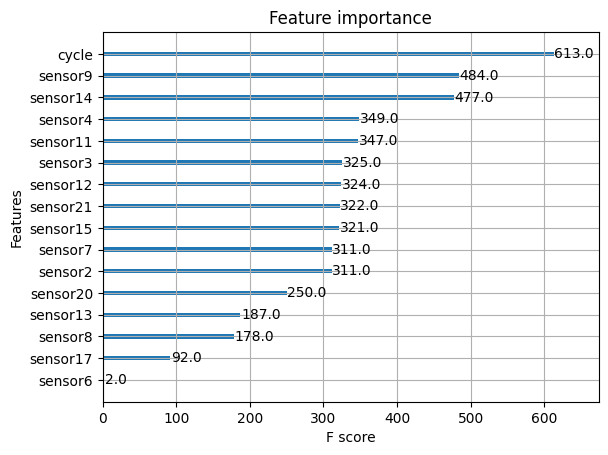

In [21]:
XGB(X_train, X_test, y_train, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

Best parameters: {'n_estimators': 188, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random Forest - Train MSE: 101.43744419132125, Train R^2: 0.9415889179947129
 Random Forest - Test MSE: 261.01254402200027, Test R^2: 0.8374632128603385
Random Forest - Mean Train Error Ratio: 0.14
Random Forest - Mean Test Error Ratio: 0.24


[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 188 out of 188 | elapsed:    0.0s finished


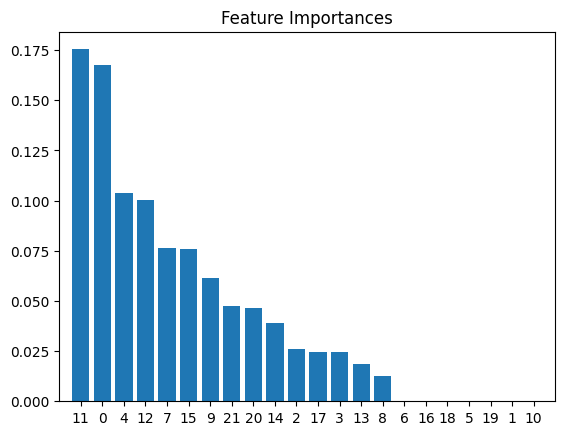

In [26]:
RF_reg(X_train, X_test, y_train, y_test)

In [29]:
Ln_reg(X_train, X_test, y_train, y_test)

Linear Regression - Train MSE: 398.69744610626367, Train R^2: 0.7704166404677217
Linear Regression - Test MSE: 458.6534429404183, Test R^2: 0.7143889872978821
Linear Regression - Mean Train Error Ratio: 0.48
Linear Regression - Mean Test Error Ratio: 0.45


In [31]:
Rd_reg(X_train, X_test, y_train, y_test)

Best parameters: {'alpha': 0.10469316005432039}
Ridge - Train MSE: 399.2289932770087, Train R^2: 0.7701105577817118
Ridge - Test MSE: 458.79897566004803, Test R^2: 0.7142983616892129
Ridge - Mean Train Error Ratio: 0.48
Ridge - Mean Test Error Ratio: 0.46


In [37]:
Rs_reg(X_train, X_test, y_train, y_test)

Rasso - Train MSE: 398.7067915267909, Train R^2: 0.7704112590611895
Rasso - Test MSE: 458.6484821498818, Test R^2: 0.7143920764634182
Rasso - Mean Train Error Ratio: 0.48
Rasso - Mean Test Error Ratio: 0.45


In [39]:
Els_reg(X_train, X_test, y_train, y_test)

Best parameters: {'alpha': 0.0004377464627927756, 'l1_ratio': 0.11582365257333607, 'max_iter': 914}
Elasticnet - Train MSE: 400.1993212882132, Train R^2: 0.7695518103735299
Elasticnet - Test MSE: 456.8696685756414, Test R^2: 0.7154997728170964
Elasticnet - Mean Train Error Ratio: 0.48
Elasticnet - Mean Test Error Ratio: 0.45
